In [1]:
import torch

In [2]:
from torch.distributions import Normal


class Arm:
    def __init__(self, mean=0.0, var=1.0, device=None):
        """
        A single arm in an n-armed bandit.

        mean, var: parameters of the reward distribution (Gaussian by default).
        """
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        # Distribution parameters
        self._mean = torch.tensor(float(mean), device=self.device)
        self._var = torch.tensor(float(var), device=self.device)

        # Underlying torch.distributions object
        self._update_distribution()

        # Count of pulls
        self.Nt = 0

        # History of rewards (can be a list or tensor; start empty)
        self.rewards = []

        # Current value estimate Q (sample-average by default)
        self.Q = 0.0

    def _update_distribution(self):
        std = torch.sqrt(self._var)
        self.dist = Normal(self._mean, std)

    # --- Distribution interface ---

    @property
    def mean(self):
        return self._mean.item()

    @property
    def var(self):
        return self._var.item()

    def set_params(self, mean=None, var=None):
        """
        Change mean and/or variance of the reward distribution.
        """
        if mean is not None:
            self._mean = torch.tensor(float(mean), device=self.device)
        if var is not None:
            if var <= 0:
                raise ValueError("Variance must be positive.")
            self._var = torch.tensor(float(var), device=self.device)
        self._update_distribution()

    # --- Interaction / reward sampling ---

    def pull(self):
        """
        Sample a reward from the arm, update Nt, reward history and Q, and return the reward.
        """
        reward = self.dist.sample().item()

        # Update count
        self.Nt += 1

        # Track reward history
        self.rewards.append(reward)

        # Incremental update of sample-average Q_t:
        # Q_{t+1} = Q_t + (1/N_t) * (R_t - Q_t)
        self.Q += (reward - self.Q) / self.Nt

        return reward

    def reset(self):
        """
        Reset statistics (Nt, rewards, Q) but keep the distribution.
        """
        self.Nt = 0
        self.rewards = []
        self.Q = 0.0

    

In [3]:
import random
from typing import Dict, List, Tuple


class Bandit:
    def __init__(
        self,
        ArmClass,
        n: int = 10,
        epsilon: float = 0.0,
        device=None,
        random_seed: int | None = None,
    ):
        """
        n          : number of arms.
        epsilon    : exploration probability (epsilon-greedy).
        ArmClass   : class used to instantiate arms (e.g., your Arm).
        random_seed: optional seed for reproducibility.
        """
        if not (0.0 <= epsilon <= 1.0):
            raise ValueError("epsilon must be in [0, 1].")

        self.n = n
        self.epsilon = float(epsilon)
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.random_seed = random_seed

        # Set seeds if provided (Python and Torch)
        if self.random_seed is not None:
            random.seed(self.random_seed)
            torch.manual_seed(self.random_seed)  # covers CPU, GPU with manual_seed_all if needed [web:37]

        # Dictionary of arms: {1: Arm(), 2: Arm(), ..., n: Arm()}
        self.arms: Dict[int, ArmClass] = {
            i: ArmClass(device=self.device) for i in range(1, n + 1)
        }

        # Call history: {t: chosen_arm_index}
        self.call_history: Dict[int, int] = {}

        # Total number of bandit calls so far
        self.t = 0

        # Bandit-level reward tracking
        self.total_reward: float = 0.0
        self.average_reward: float = 0.0

    # --- Preference structure ---

    @property
    def preferences(self) -> List[Tuple[int, float, float]]:
        """
        Empirical preference structure of arms.

        Returns a list of (arm_index, Q_value, variance) sorted:
        - descending by Q_value
        - ties broken by ascending variance
        """
        entries = []
        for idx, arm in self.arms.items():
            entries.append((idx, arm.Q, arm.var))

        # Sort: highest Q first, then lowest variance, then smallest index
        entries.sort(key=lambda x: (-x[1], x[2], x[0]))
        return entries

    def best_arm_indices(self) -> List[int]:
        """
        Return the indices of the empirically best arms
        according to Q, with tie-breaking by variance and then index.
        """
        prefs = self.preferences
        if not prefs:
            return []

        best_Q = prefs[0][1]
        best = [p for p in prefs if p[1] == best_Q]

        # Among those, keep only minimum variance
        min_var = min(p[2] for p in best)
        best = [p for p in best if p[2] == min_var]

        return [p[0] for p in best]

    # --- Action selection ---

    def _choose_arm_index(self) -> int:
        """
        Epsilon-greedy selection:
        - With probability 1 - epsilon: choose empirically best arm.
        - With probability epsilon: choose an arm uniformly at random.
        """
        if random.random() < self.epsilon:
            # Exploration
            return random.randint(1, self.n)

        # Exploitation
        best_indices = self.best_arm_indices()

        if len(best_indices) == 1:
            return best_indices[0]

        # Still tied after Q and variance -> random among them
        return random.choice(best_indices)

    # --- Interaction with environment ---

    def select_and_pull(self) -> Tuple[int, float]:
        """
        Select an arm according to epsilon-greedy policy, pull it,
        update internal logs and bandit-level rewards, and return (chosen_arm_index, reward).
        """
        self.t += 1

        chosen_idx = self._choose_arm_index()
        chosen_arm = self.arms[chosen_idx]

        reward = chosen_arm.pull()  # updates arm.Nt, arm.rewards, arm.Q

        # Log which arm was chosen at this bandit call
        self.call_history[self.t] = chosen_idx

        # Update bandit-level reward statistics
        self.total_reward += reward
        self.average_reward = self.total_reward / self.t

        return chosen_idx, reward

    def reset(self, reset_arms: bool = True):
        """
        Reset bandit-level state.
        If reset_arms is True, also reset each arm's statistics.
        """
        self.t = 0
        self.call_history = {}
        self.total_reward = 0.0
        self.average_reward = 0.0

        if reset_arms:
            for arm in self.arms.values():
                arm.reset()


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def init_bandit_with_true_means(BanditClass, ArmClass, n_arms=10, epsilon=0.0, seed=None):
    """
    Create one bandit with n_arms, sample true means ~ N(0,1),
    and set each arm's distribution to Normal(true_mean, 1).
    Returns (bandit, true_means, optimal_arm_index).
    """
    rng = np.random.RandomState(seed)
    true_means = rng.normal(loc=0.0, scale=1.0, size=n_arms)  # q* ~ N(0,1) [web:47]

    bandit = BanditClass(ArmClass=ArmClass, n=n_arms, epsilon=epsilon, random_seed=seed)

    for i, m in enumerate(true_means, start=1):
        bandit.arms[i].true_mean = m    # store true mean on the arm
        bandit.arms[i].set_params(mean=m, var=1.0)

    optimal_arm = int(np.argmax(true_means)) + 1  # 1-based index
    return bandit, true_means, optimal_arm


In [5]:
def run_experiment(BanditClass, ArmClass,
                   n_bandits=2000, n_arms=10, n_steps=1000, epsilon=0.0, base_seed=0):
    """
    Returns:
        avg_reward:      shape (n_steps,), average reward across bandits at each step
        pct_optimal:     shape (n_steps,), % of bandits choosing optimal arm at each step (0..100)
    """
    rewards_all = np.zeros((n_bandits, n_steps))
    optimal_choice_all = np.zeros((n_bandits, n_steps), dtype=bool)

    bandits = {}


    for b in range(n_bandits):
        seed = base_seed + b
        bandit, true_means, optimal_arm = init_bandit_with_true_means(
            BanditClass, ArmClass, n_arms=n_arms, epsilon=epsilon, seed=seed
        )

        bandits[b] = {
            "bandit": bandit,
            "true_means": true_means,
            "optimal_arm": optimal_arm,
        } 

        for t in range(n_steps):
            chosen_arm, reward = bandit.select_and_pull()
            rewards_all[b, t] = reward
            optimal_choice_all[b, t] = (chosen_arm == optimal_arm)

    avg_reward = rewards_all.mean(axis=0)
    pct_optimal = optimal_choice_all.mean(axis=0) * 100.0
    return bandits, avg_reward, pct_optimal


In [6]:
def compute_regret_curve_for_bandit(bandit_entry, n_steps):
    """
    bandit_entry: one entry from the bandits dict, e.g. bandits[b]
        expected keys: "bandit", "true_means", "optimal_arm"
    n_steps: number of time steps simulated

    Returns:
        regret: shape (n_steps,), cumulative regret over time
    """
    bandit = bandit_entry["bandit"]
    true_means = bandit_entry["true_means"]
    optimal_arm = bandit_entry["optimal_arm"]

    mu_star = true_means[optimal_arm - 1]  # optimal mean

    regret = np.zeros(n_steps)

    for t in range(1, n_steps + 1):
        chosen_arm = bandit.call_history[t]
        mu_chosen = true_means[chosen_arm - 1]
        instantaneous_regret = mu_star - mu_chosen
        regret[t - 1] = instantaneous_regret if t == 1 else regret[t - 2] + instantaneous_regret

    return regret


In [7]:
def compute_average_regret_for_epsilon(bandits_dict, n_steps):
    """
    bandits_dict: output from run_experiment for a given epsilon
    Returns:
        avg_regret: shape (n_steps,), mean cumulative regret across bandits
    """
    n_bandits = len(bandits_dict)
    regrets = np.zeros((n_bandits, n_steps))

    for b, entry in bandits_dict.items():
        regrets[b, :] = compute_regret_curve_for_bandit(entry, n_steps)

    avg_regret = regrets.mean(axis=0)
    return avg_regret

In [8]:
epsilons = [0.0, 0.1, 0.01]

results = {}
for eps in epsilons:
    bandits, avg_R, pct_opt = run_experiment(
        BanditClass=Bandit,
        ArmClass=Arm,
        n_bandits=2000,
        n_arms=10,
        n_steps=1000,
        epsilon=eps,
        base_seed=1234
    )

    avg_regret = compute_average_regret_for_epsilon(bandits, n_steps=1000)
    results[eps] = {"bandits": bandits, "avg_reward": avg_R, "pct_optimal": pct_opt, "avg_regret": avg_regret}


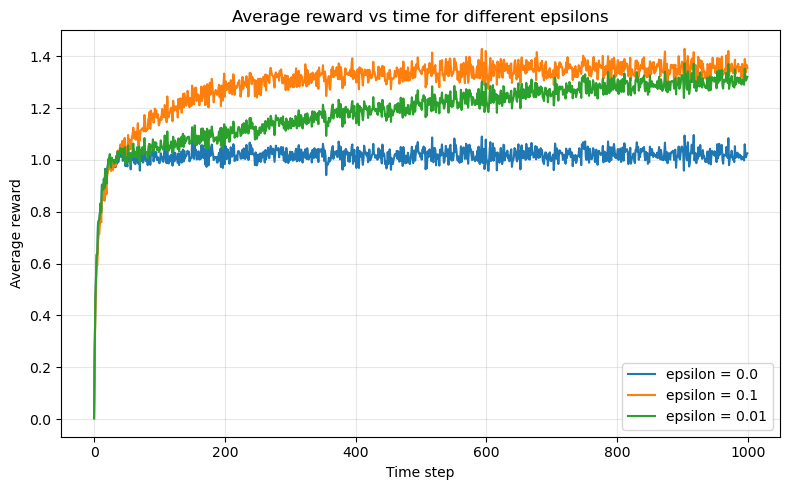

In [9]:
plt.figure(figsize=(8, 5))
for eps in epsilons:
    plt.plot(results[eps]["avg_reward"], label=f"epsilon = {eps}")
plt.xlabel("Time step")
plt.ylabel("Average reward")
plt.title("Average reward vs time for different epsilons")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


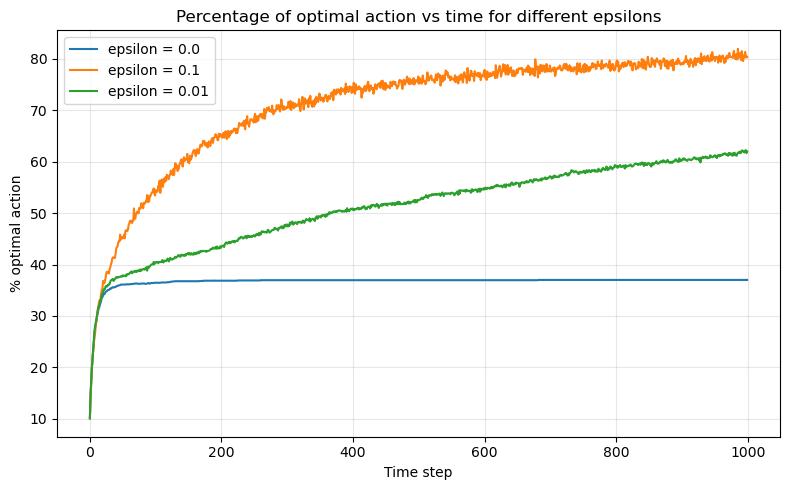

In [10]:
plt.figure(figsize=(8, 5))
for eps in epsilons:
    plt.plot(results[eps]["pct_optimal"], label=f"epsilon = {eps}")
plt.xlabel("Time step")
plt.ylabel("% optimal action")
plt.title("Percentage of optimal action vs time for different epsilons")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


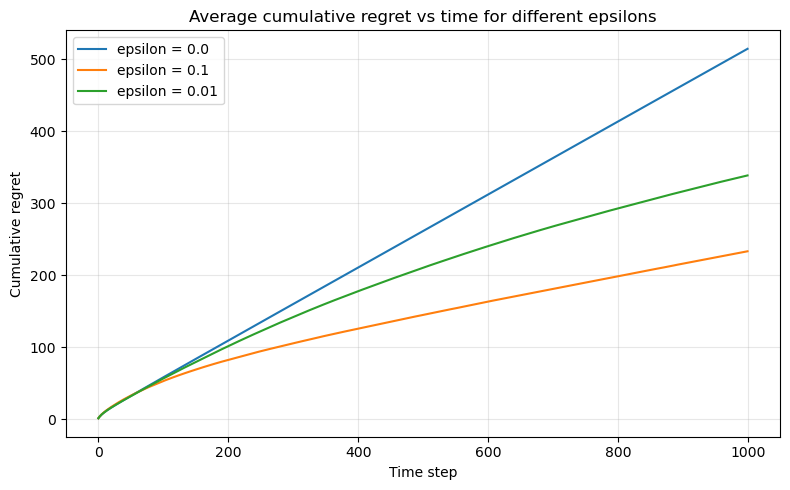

In [13]:
plt.figure(figsize=(8, 5))
for eps in epsilons:
    plt.plot(results[eps]["avg_regret"], label=f"epsilon = {eps}")
plt.xlabel("Time step")
plt.ylabel("Cumulative regret")
plt.title("Average cumulative regret vs time for different epsilons")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
results

{0.0: {'bandits': {0: {'bandit': <__main__.Bandit at 0x7f1f89ea9940>,
    'true_means': array([ 0.47143516, -1.19097569,  1.43270697, -0.3126519 , -0.72058873,
            0.88716294,  0.85958841, -0.6365235 ,  0.01569637, -2.24268495]),
    'optimal_arm': 3},
   1: {'bandit': <__main__.Bandit at 0x7f1f89ec91d0>,
    'true_means': array([ 0.68938232, -0.03171215,  0.66805361,  0.48883782, -0.67978825,
           -1.30747938,  1.47030437, -1.23102724,  0.95877525,  0.74048962]),
    'optimal_arm': 7},
   2: {'bandit': <__main__.Bandit at 0x7f1f89ec8f50>,
    'true_means': array([-0.09375848, -1.69935067,  0.40455707, -1.39563456, -1.35254219,
           -0.76516263, -1.3732163 , -2.00312241,  0.33949538, -0.07418577]),
    'optimal_arm': 3},
   3: {'bandit': <__main__.Bandit at 0x7f1f89fe9220>,
    'true_means': array([ 0.94119621,  0.96945322, -1.14209044, -0.75449936, -0.35740697,
           -0.03253859,  0.47522816,  0.37692263, -0.38936429,  0.47639215]),
    'optimal_arm': 2},
   4